# 时序定义与基本任务

&emsp;&emsp;**时间序列**（time series）是一组按照时间发生先后顺序进行排列的数据点序列。通常一组时间序列的时间间隔为一恒定值，因此时间序列数据可以作为离散时间数据进行分析处理。时间序列无处不在：CPU负载、上证指数、商场人流量、商品价格等。  
&emsp;&emsp;如下有一组简单的测试数据，导入到python中进行预览。

In [1]:
#导入常用的库。
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
data = pd.read_csv('E:\\py4e\\article\\test_data.csv')
#预览数据的值与格式。
print (data)
print ('\n Data types:')
print (data.dtypes)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]

 Data types:
Month          object
#Passengers     int64
dtype: object


&emsp;&emsp;对时序数据的处理有下列基本任务：
* **单指标时序数据预测任务**：给定某一个指标的历史变化情况，预测其一段时间内的变化。
* **多指标时序预测任务**：给定某几个指标的历史变化情况，预测其一段时间内的变化。与单指标时序预测任务的区别在于，几个指标之间不一定相互独立，而是存在某种影响。
* **时序数据异常检测任务**：从正常的时间序列中识别不正常的事件或行为的过程。可以从历史数据中检测，也可以基于时序预测对尚未发生的异常做出预警。
* **时序指标聚类**：将变化趋势类似的时序指标归至同一类别。在实际运维工作中，面对的指标可能成百上千，分别对其进行分析，工作量太大，可以在聚类的基础上再做建模分析。
* **指标关联分析**：即分析指标A是否会对指标B有影响，以及有什么样的影响（正向/负向、先后关系、多少时间步后造成影响等等）。

# 时序数据的平稳性
## 平稳性的检测
**平稳性**是时序数据的重要指标，时序分析基本上是以平稳的时序数据为基础的。而平稳性又包括强平稳与**弱平稳**，强平稳的证明比较困难，因此一般来说，常见的时序分析是基于**弱平稳**的。  
&emsp;&emsp;弱平稳简单来说需要满足以下几点：  
* 均值为常数
* 方差收敛
* 协方差只与时间间隔有关（记时间间隔$lag = k$,则协方差为Cov($x_{t},x_{t-k}$)）。    

&emsp;&emsp;可以通过python作图来直观表示数据的均值与方差。但这显然是不严谨的，因此我们需要更有说服力、更加客观的统计方法或者特定系数来帮助我们检验时间序列的平稳性，例如：单位根检验（Dickey-Fuller test），自相关系数ACF，偏相关系数PACF等。

In [3]:
#将数据的索引（index）更改为month，并进行格式转换。
from datetime import datetime
dateparse = lambda dates_in: datetime.strptime(dates_in, '%Y-%m')
#parse_dates 表明选择数据中的哪个column作为date-time信息。
#index_col 告诉 pandas以哪个column作为index。
#date_parser 用来配合 parse_dates参数，因为有的列虽然是日期，但没办法直接转化，需要我们指定一个解析格式。
data = pd.read_csv('E:\\py4e\\article\\test_data.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print (data.head())
print (data.index)

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


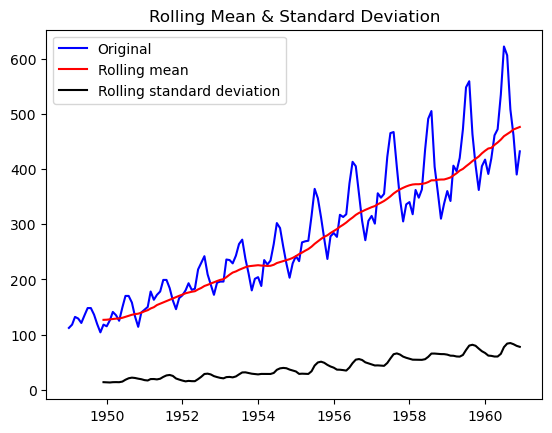

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [4]:
from statsmodels.tsa.stattools import adfuller
def test_DF_test(timeseries):
     #以12个月为一个窗口，进行期望和标准差的计算。
     rolmean = timeseries.rolling(12).mean()
     rolstd = timeseries.rolling(12).std()

     #绘图
     fig = plt.figure()
     ax1 = fig.add_subplot()
     ax1.plot(timeseries, color = 'blue',label='Original')
     ax1.plot(rolmean, color = 'red',label = 'Rolling mean')
     ax1.plot(rolstd, color = 'black', label= 'Rolling standard deviation')

     plt.legend(loc = 'best')
     plt.title('Rolling Mean & Standard Deviation')
     plt.show()

     #Dickey-Fuller test：
     print ('Results of Dickey-Fuller Test:')
     dftest = adfuller(timeseries,autolag = 'AIC')
     #dftest的输出前一项依次为检测值，p值，滞后数，使用的观测数，各个置信度下的临界值。
     dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
     for key,value in dftest[4].items():
          dfoutput['Critical Value (%s)' %key] = value
    
     print (dfoutput)

ts = data['#Passengers']
test_DF_test(ts)

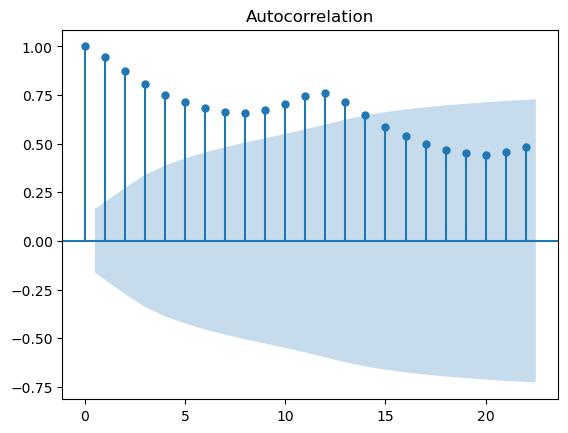

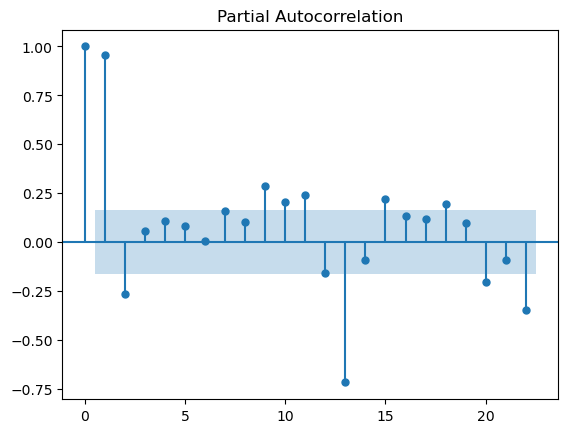

In [5]:
#计算数据的ACE值与PACF值。
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_ts = plot_acf(ts)
pacf_ts = plot_pacf(ts)

plt.show()

&emsp;&emsp;从这组数据的rolling均值/标准差来看，二者都具有越来越大的趋势；从单位根检验的结果来看，在任何置信度下，数据都不是稳定的（Test Statistic与Critical Value比较时应考虑正负，不能比较绝对值）；并且对于一个平稳时间序列，自相关系数（ACF）会快速的下降到接近0的水平，然而非平稳时间序列的自相关系数会下降的比较缓慢。综上，这组数据是非平稳的。

## 如何使数据趋于平稳？
&emsp;&emsp;即便数据原本是不稳定的，但是通过一定的处理，可以让时序数据变得稳定。让数据变得不稳定的原因有：**1、趋势**，**2.季节性**。以本次使用的数据为例，航班不仅会随着科技的进步逐渐增加，而且会受到季节性的影响（节假日）。  
&emsp;&emsp;模型的根本原理是建模或估计序列中的的趋势和季节性，从序列中删除这些因素，得到一个平稳的序列。然后统计预测技术可以在这个序列上完成。最后一步是通过运用趋势和季节性约束将预测值转换成原来的区间。  
&emsp;&emsp;对于**趋势**，消除他的第一步往往需要**变换**。在本次使用的数据中，我们需要*惩罚较高值而不惩罚较小值*，可以采用对数log，平方根，立方根等等。  
&emsp;&emsp;在使用相应的变换后，数据很有可能仍然呈现出某种趋势，因此我们可以使用一些技术来估计或对这个趋势建模,然后将它从序列中删除。这里有很多方法,最常用的有:
>>聚合：取一段时间的平均值（月/周平均值）  
>>平滑：取滚动平均数  
>>多项式拟合：拟合一个回归模型

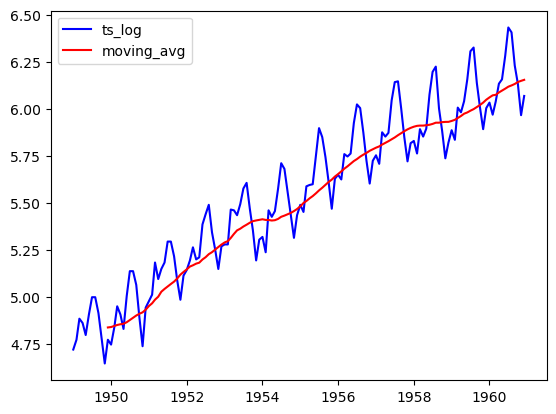

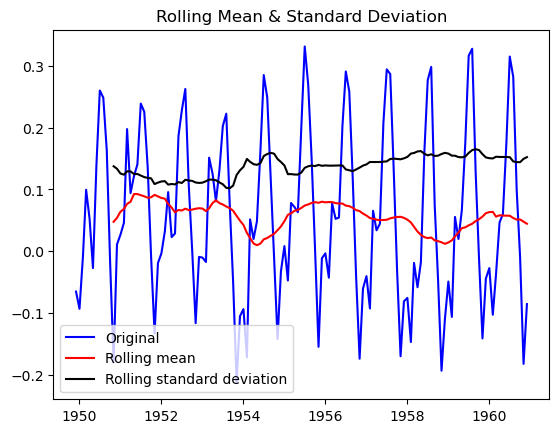

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [6]:
#取对数后作图。
ts_log = np.log(ts)
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log ,color = 'blue', label = 'ts_log')
plt.plot(moving_avg, color='red', label = 'moving_avg')

plt.legend(loc = 'best')
plt.show()

#做差后，使用test_DF_test函数处理数据。
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace = True) #最开始的11个月没有滚动平均，舍弃。
test_DF_test(ts_log_moving_avg_diff)

&emsp;&emsp;这里采用了**移动平均**的方法，根据时间序列的周期，选择12个月作为moving_avg的rolling参数，再进行test_DF_test函数运算之后，得到了一个较为平稳的序列，其p-value小于5%，因此在95%的置信区间下，可以认为它是平稳序列。  
&emsp;&emsp;这种方法对所有数据一视同仁，但一般来说，在某些特定领域，时间上越靠近现在的数据越具有参考价值。因此，我们可以选择**指数加权平均移动法**来处理数据，给最近的值赋予更高的权重。这种方法涉及到一个关于衰减的参数，这很大程度上取决于具体领域的其他参数，如跨度（span）、质心（center of mass）等等。

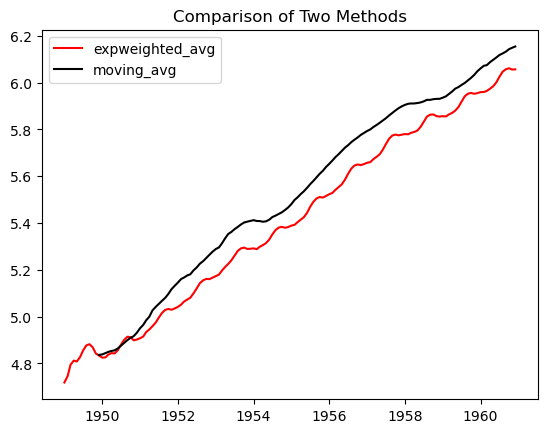

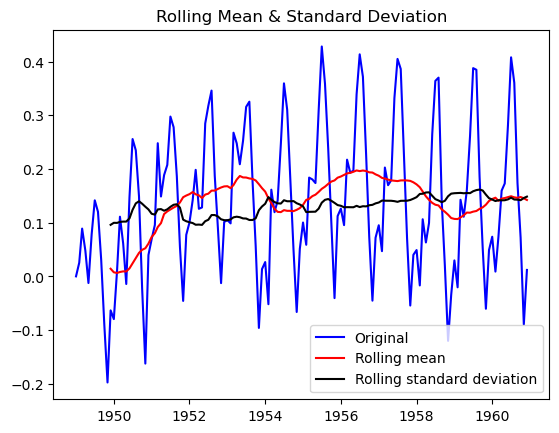

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
expweighted_avg = pd.Series(ts_log).ewm(halflife=12).mean() #选择12个月的半衰期来表征权重。
plt.plot(expweighted_avg, color='red', label = 'expweighted_avg')
plt.plot(moving_avg, color='black', label = 'moving_avg')

plt.legend(loc = 'best')
plt.title('Comparison of Two Methods')
plt.show()

ts_log_exp_diff = ts_log - expweighted_avg
test_DF_test(ts_log_exp_diff)

&emsp;&emsp;从图“Comparison of Two Methods”中可以发现，指数加权平均移动法处理数据时，前12个月也有数据。这种方法下，得到的时间序列的平均值和标准差变化更小，test statistic也小于1%的critical value，说明数据更加地平稳。  
&emsp;&emsp;除此以外，消除趋势与季节性的方法还有**差分**、**分解**等，在代码中可以得到直观的体现。

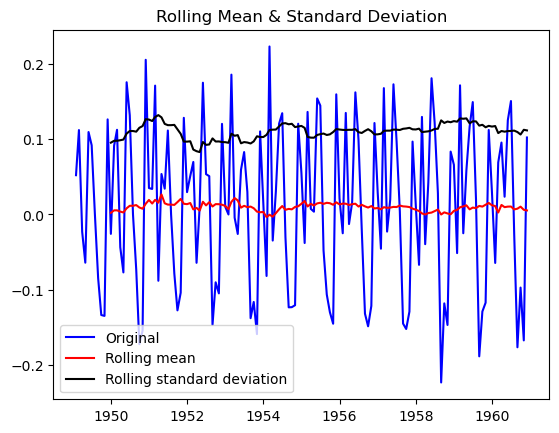

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


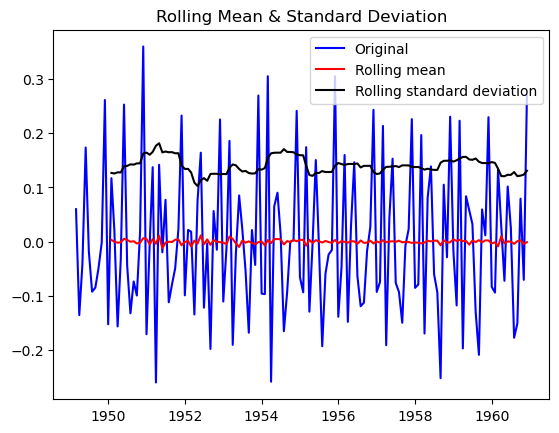

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [8]:
#Differencing
def data_diff(ts_in,k):
    i = 0
    while i < k:
        ts_in = ts_in - ts_in.shift()
        i += 1
    return ts_in

#一阶差分
ts_log_first_diff = data_diff(ts_log,1)
ts_log_first_diff.dropna(inplace=True)
test_DF_test(ts_log_first_diff)

#二阶差分
ts_log_second_diff = data_diff(ts_log,2)
ts_log_second_diff.dropna(inplace=True)
test_DF_test(ts_log_second_diff)

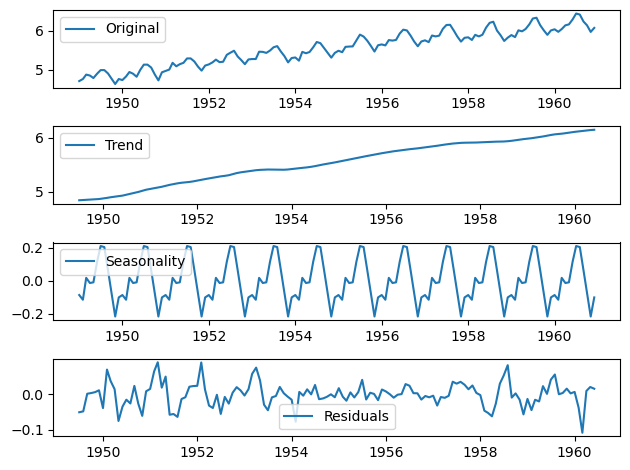

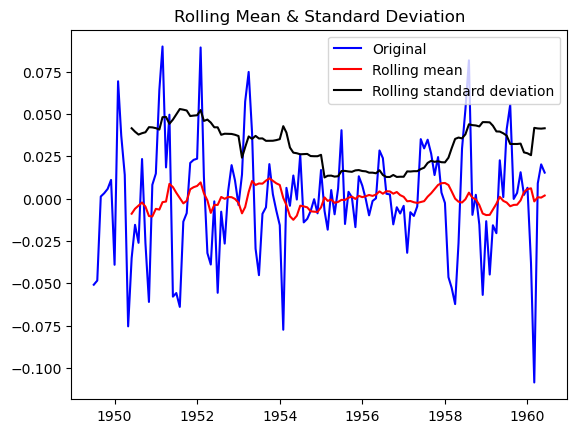

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [9]:
#Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose # 一种分解方法。
def decompose(deco_in):
    #预处理
    decomposition = seasonal_decompose(deco_in)
    
    trend = decomposition.trend #趋势部分
    seasonal = decomposition.seasonal #季节性部分
    residual = decomposition.resid #残留部分
    
    plt.subplot(411) #以4行1列输出子图
    plt.plot(deco_in, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout() 
    plt.show()
    return trend , seasonal, residual

trend , seasonal, residual = decompose(ts_log)
residual.dropna(inplace = True)
test_DF_test(residual)

&emsp;&emsp;如图，original数据拆分成了三份。Trend数据具有明显的趋势性，Seasonality数据具有明显的周期性，Residuals是剩余的部分，可供我们进行时序数据的处理。发现数据的均值和方差趋于常数，波动的值域基本上为[-0.05,0.05]，数据基本稳定，同时p值也说明了这一点。不过通过这种方法转换回原始数据进行预测，显得不是很直观。

# 时间序列预测  
## 时间序列分解  
&emsp;&emsp;以上种种时间序列趋于平稳的方法，系统地来说，应该叫时间序列的分解，指将时间序列分解为三部分：趋势项、季节项、残差项。一般包括乘性分解与加性分解，前者即时间序列=趋势项\*季节项\*残差项，后者即时间序列=趋势项+季节项+残差项。如果季节性波动的幅度或者趋势周期项的波动不随时间序列水平的变化而变化，那么加法模型是最为合适的。当季节项或趋势周期项的变化与时间序列的水平成比例时，则乘法模型更为合适。例如，在经济时间序列中，乘法模型较为常用。
## 常见的分解方法  
### 经典分解法  
&emsp;&emsp;经典算法步骤相对简单，它假设周期性成分在每个周期内都是相同的（如每年的月周期成分都相同），并使用移动平均法处理数据。首先估计周期长度，以一周期为区间，对一块块数据取均值，得出趋势。然后使用原数据减去趋势，求不同块数据的均值，得出周期序列，而后根据该二者得出残差。乘法性模型的求解方法类似。  
### X11分解法  
&emsp;&emsp;X11方法基于经典分解法，包括很多其它的步骤和特点来克服经典分解法的一些不足。X11有一些复杂的方法来处理交易日、假期及一些其它已知的影响因素的影响。还有一些其他的分解方法：SEATS分解法、STL分解法、fbprophet分解。

## ARIMA模型  
### 简介
&emsp;&emsp;在许多的时间序列预测模型中，差分的运用非常广泛，更容易添加噪音和对预测的残差进行季节性回退。在完成了趋势和季节性估计和消除技术后,有两种情况:  
* 不含依赖值的严格平稳序列。简单的情况下,我们可以将残差作为白噪音。但这是非常罕见的。  
* 序列含有明显的依赖值。在这种情况下,我们需要使用一些统计模型像ARIMA来预测数据。  

&emsp;&emsp;ARIMA模型的全称叫做自回归移动平均模型(Autoregressive Integrated Moving Average Model)。也记作ARIMA(p,d,q)，是统计模型(statistic model)中最常见的一种用来进行时间序列预测的模型。  
### 优缺点  
优点：
模型十分简单，只需要内生变量而不需要借助其他外生变量。  
缺点：  
1.要求时序数据是稳定的（stationary），或者是通过差分化(differencing)后是稳定的。  
2.本质上只能捕捉线性关系，而不能捕捉非线性关系。
注意，采用ARIMA模型预测时序数据，必须是稳定的，如果不稳定的数据，是无法捕捉到规律的。比如股票数据用ARIMA无法预测的原因就是股票数据是非稳定的，常常受政策和新闻的影响而波动。
### 数学形式
ARIMA模型有三个参数:p,d,q：
>> p--代表预测模型中采用的时序数据本身的滞后数(lags) ,也叫做AR/Auto-Regressive项。  
>> d--代表时序数据需要进行几阶差分化，才是稳定的，也叫Integrated项。  
>> q--代表预测模型中采用的预测误差的滞后数(lags)，也叫做MA/Moving Average项。  

ARIMA的预测模型可以表示为：  
>> Y的预测值 = 常量c and/or 一个或多个最近时间的Y的加权和 and/or 一个或多个最近时间的预测误差。  

假设p，q，d已知，ARIMA用数学形式表示为：  
>> y(t)=μ+ϕ(1)∗y(t−1)+...+ϕ(p)∗y(t−p)+θ1∗e(t−1)+...+θq∗e(t−q)  

其中，ϕ表示p，即AR的系数；θ表示q，即MA的系数。

D:\ANACONDA\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


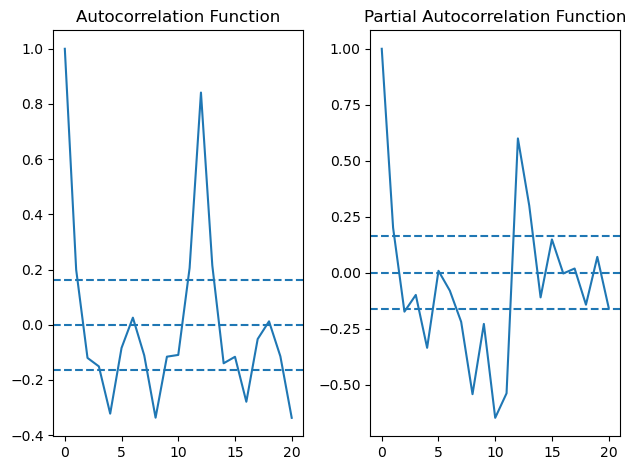

In [10]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_first_diff, nlags=20)
lag_pacf = pacf(ts_log_first_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
#置信区间
plt.axhline(y=-1.96/np.sqrt(len(ts_log_first_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(ts_log_first_diff)),linestyle='--')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_first_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(ts_log_first_diff)),linestyle='--')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

&emsp;&emsp;在这两幅图中，我们可以根据曲线与上层置信区间第一次相交时的横坐标，来确定相应的p与q。这里取p = 2，q = 2。（这种方法基于感性认识，还有拖尾/截尾、快速下降、明显突起等判断方式，是不够精确的，在工程上，一般以**AIC/BIC信息准则**作为变量的选择依据）。

D:\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


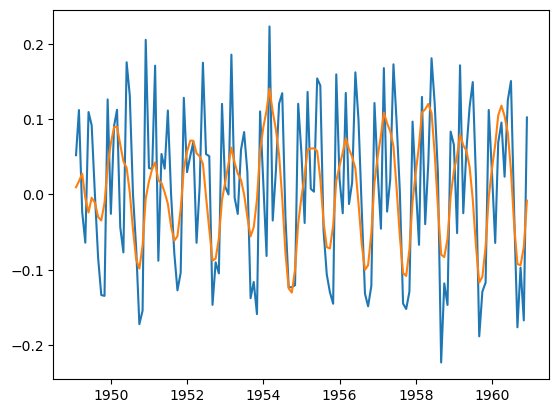

In [33]:
from statsmodels.tsa.arima_model import ARIMA
ts_log_first_diff.dropna(inplace=True)
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_first_diff)
plt.plot(results_ARIMA.fittedvalues)
plt.show()

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64
Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64
Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64


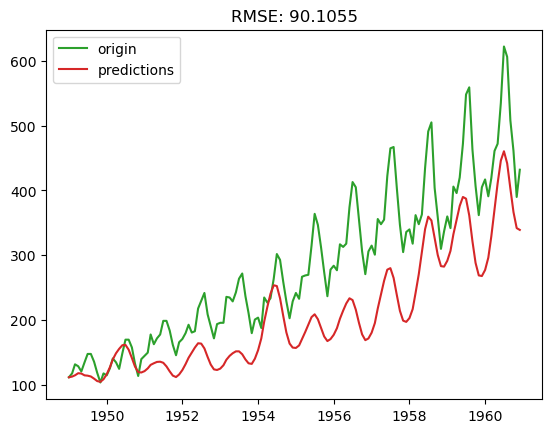

In [37]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts, label = 'origin')
plt.plot(predictions_ARIMA, label = 'predictions')

plt.legend(loc = 'best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts))) #计算均方根误差。
plt.show()